In [1]:
import numpy as np
from scipy.linalg import logm
import csv
import configparser
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s",
                    handlers=[logging.StreamHandler(), logging.FileHandler("log.txt", "w")])

from joint import RevoluteJoint
from robot import Robot
from utils import extract_screw_from_logm

In [2]:
def get_UR5_robot():
    """
    Screw axis S_1: [ 0.  0.  1. -0. -0. -0.]
    Screw axis B_1: [ 0.     1.     0.     0.191 -0.     0.817]

    Screw axis S_2: [ 0.     1.     0.    -0.089 -0.    -0.   ]
    Screw axis B_2: [ 0.     0.     1.     0.095 -0.817 -0.   ]

    Screw axis S_3: [ 0.     1.     0.    -0.089 -0.     0.425]
    Screw axis B_3: [ 0.     0.     1.     0.095 -0.392 -0.   ]

    Screw axis S_4: [ 0.     1.     0.    -0.089 -0.     0.817]
    Screw axis B_4: [ 0.     0.     1.     0.095 -0.    -0.   ]

    Screw axis S_5: [ 0.     0.    -1.    -0.109  0.817 -0.   ]
    Screw axis B_5: [ 0.    -1.     0.    -0.082 -0.    -0.   ]

    Screw axis S_6: [ 0.     1.     0.     0.006 -0.     0.817]
    Screw axis B_6: [ 0.  0.  1.  0. -0. -0.]  
    """
    
    names = ['joint1','joint2','joint3', 'joint4', 'joint5', 'joint6']
    W1 = 109/1000
    W2 = 82/1000
    L1 = 425/1000
    L2 = 392/1000
    H1 = 89/1000
    H2 = 95/1000

    joint1 = RevoluteJoint(name=names[0], position=np.array([0, 0, H1]), rotation_axis=np.array([0, 0, 1]))
    joint2 = RevoluteJoint(name=names[1], position=np.array([0, W1, H1]), rotation_axis=np.array([0, 1, 0]))
    joint3 = RevoluteJoint(name=names[2], position=np.array([L1, W1, H1]), rotation_axis=np.array([0, 1, 0]))
    joint4 = RevoluteJoint(name=names[3], position=np.array([L1+L2, 0, H1]), rotation_axis=np.array([0, 1, 0]))
    joint5 = RevoluteJoint(name=names[4], position=np.array([L1+L2, W1, H1]), rotation_axis=np.array([0, 0, -1]))
    joint6 = RevoluteJoint(name=names[5], position=np.array([L1+L2, W1, H1-H2]), rotation_axis=np.array([0, 1, 0]))

    base_position = np.array([0, 0, 0])
    base_orientation = np.eye(3)

    end_effector_position = np.array([L1+L2, W1+W2, H1-H2])
    end_effector_orientation = np.array([[-1,0, 0],
                                        [0,0, 1],
                                        [0,1, 0]])

    rb = Robot()
    rb.register_joint(joint=joint1)
    rb.register_joint(joint=joint2)
    rb.register_joint(joint=joint3)
    rb.register_joint(joint=joint4)
    rb.register_joint(joint=joint5)
    rb.register_joint(joint=joint6)

    rb.base_frame.update_orientation(base_position)
    rb.base_frame.update_orientation(base_orientation)
    rb.end_effector_frame.update_position(end_effector_position)
    rb.end_effector_frame.update_orientation(end_effector_orientation)
    return rb

In [3]:
def newton_raphson_inverse_kinematics(rb, thetas_0, T_sd, num_iters, lr_generator, epsilon=1e-6):
    """
    Compute joint angles using the Newton-Raphson method.
    
    :param rb: Robot instance.
    :param thetas_0: Initial joint angles.
    :param T_sd: Desired SE(3) matrix.
    :param num_iters: Maximum number of iterations for the Newton-Raphson method.
    :param lr_generator: Generator for the learning rate.
    :param epsilon: Convergence threshold.
    
    :return: History of joint angles over the iterations.
    """
    
    # Initialize current joint angles to the initial values
    thetas = thetas_0
    
    # Get the names of the joints
    names = rb.joint_names

    # Start the list for recording joint angles history
    thetas_history = [np.round(thetas,6)]
    
    # Start the Newton-Raphson method iterations
    for i in range(num_iters):
        # Log current iteration number
        logger.info(f"iteration {i+1}:")
        
        # Convert the list of joint angles to a dictionary format for easier lookup
        theta_dict = dict(zip(names, thetas))
        
        # Calculate the current SE(3) matrix
        T_sb = rb.get_total_SE3(theta_dict, isSpace=True)
        
        # Calculate the error in SE(3) space
        T_bd = np.matmul(np.linalg.inv(T_sb), T_sd)

        # Compute the SE(3) logarithm of the error matrix
        V_b_se3 = logm(T_bd)
        
        # Extract the screw motion (angular and linear velocity) from the SE(3) logarithm
        w, v = extract_screw_from_logm(V_b_se3)
        
        # Combine angular and linear velocities into a single vector
        V_b = np.hstack([w, v])

        # Calculate the Jacobian in the base frame
        J = rb.get_jacobian_base(theta_dict, isSpace=False)
        
        # Calculate the change in joint angles for this iteration
        delta_theta = np.matmul(np.linalg.pinv(J), V_b)
        error_theta = np.linalg.norm(delta_theta)

        # Log the current end-effector configuration and error
        logger.info("SE(3) end - effector config: ")
        logger.info(np.round(T_bd,3))
        logger.info(f"error twist V_B: {np.round(V_b,3)}")
        
        # Compute and log the magnitude of the angular and linear errors
        error_omega_b = np.linalg.norm(V_b[:3])
        error_v_b = np.linalg.norm(V_b[3:])
        logger.info(f"angular error magnitude [omega_b]: {np.round(error_omega_b,3)}")
        logger.info(f"linear error magnitude [v_b]: {np.round(error_v_b, 3)}")
        
        # Check for convergence of the algorithm
        if (error_omega_b < epsilon) and (error_v_b < epsilon) and (error_theta < epsilon):
            break

        # Get the current learning rate
        alpha = next(lr_generator)
        
        # Update joint angles
        thetas = thetas + alpha*delta_theta

        # Record the current joint angles to the history list
        thetas_history.append(np.round(thetas,6))
        logger.info('')  
    
    return thetas_history

In [4]:
class MexicanHatLearningRate:
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        :param min_lr: Minimum learning rate
        :param max_lr: Maximum learning rate
        :param cycle_length: Number of steps for a complete cycle
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.step = 0
        self.set_raw_values()

    def mexican_hat(self, t):
        return (1 - 2*np.pi**2 * t**2) * np.exp(-np.pi**2 * t**2)
    
    def set_raw_values(self):
        steps = np.arange(self.cycle_length)
        t = (2 * steps / self.cycle_length) - 1 
        raw_values = self.mexican_hat(t)
        raw_values -= raw_values.min()
        raw_values /= raw_values.max()

        self.raw_values = self.min_lr + raw_values*(self.max_lr - self.min_lr)

    def __iter__(self):
        return self

    def __next__(self):

        # Normalize and scale the value to the range [min_lr, max_lr]
        lr = self.raw_values[self.step] 
        self.step += 1
        return lr

In [5]:
def save_to_csv(items, filename="output.csv"):
    with open(filename, 'w', newline='') as csvfile:
        # Write the header directly to the file
        csvfile.write("# 6-DOF UR5 robot arm csv file for V-REP animation.\n")
        csvfile.write("# All lines beginning with # are treated as a comment and ignored.\n")
        csvfile.write("# Each line below is of the form\n")
        csvfile.write("# jt1ang, jt2ang, jt3ang, jt4ang, jt5ang, jt6ang\n")
        csvfile.write("# where each joint angle is expressed in radians.\n")
        
        # Now use the CSV writer for the items
        writer = csv.writer(csvfile)
        writer.writerows(items)
        csvfile.close()

def clear_logger_handlers(logger):
    while logger.handlers:
        handler = logger.handlers[0]
        handler.close()
        logger.removeHandler(handler)

def parse_config(filename="./config.ini"):
    """
    Parse the configuration file to extract desired SE(3) matrix and initial joint angles.
    
    :param filename: Path to the configuration file.
    
    :return: T_sd (desired SE(3) matrix) and thetas_0 (initial joint angles).
    """
    
    # Initialize the ConfigParser object
    config = configparser.ConfigParser()
    
    # Read the configuration file
    config.read(filename)
    
    # Extract and convert the desired SE(3) matrix from the config file into a numpy array
    T_sd_list = [float(i) for i in config["data"]["T_sd"].split(",")]
    T_sd = np.array(T_sd_list).reshape(4, 4)

    # Extract and convert the initial joint angles from the config file into a numpy array
    thetas_0 = np.array([float(i) for i in config["data"]["thetas_0"].split(",")])

    return T_sd, thetas_0

In [6]:
T_sd, thetas_0 = parse_config()
# Obtain the UR5 robot instance for further operations
rb = get_UR5_robot()

# Define the maximum number of epochs for the Newton-Raphson method
MAX_EPOCHES = 300

# Initialize a learning rate generator using the Mexican Hat function
# The learning rate will cyclically increase and decrease within the specified range over the defined epochs
lr_generator = MexicanHatLearningRate(min_lr=0.005, max_lr=0.08, cycle_length=MAX_EPOCHES)

# Use the Newton-Raphson method to calculate the joint angles over iterations
thetas_history = newton_raphson_inverse_kinematics(rb, thetas_0=thetas_0, T_sd=T_sd, num_iters=MAX_EPOCHES, lr_generator=lr_generator)

# Save the joint angles' history to a CSV file
save_to_csv(thetas_history)

# Clear any existing logger handlers for clean logging in future runs
clear_logger_handlers(logger)

iteration 1:
SE(3) end - effector config: 
[[-0.146  0.25   0.957 -0.59 ]
 [ 0.854 -0.457  0.25   0.951]
 [ 0.5    0.854 -0.146 -0.381]
 [ 0.     0.     0.     1.   ]]
error twist V_B: [ 1.643  1.245  1.643  0.753  0.447 -1.342]
angular error magnitude [omega_b]: 2.636
linear error magnitude [v_b]: 1.603

iteration 2:
SE(3) end - effector config: 
[[-0.126  0.198  0.972 -0.553]
 [ 0.882 -0.425  0.202  0.946]
 [ 0.453  0.883 -0.121 -0.41 ]
 [ 0.     0.     0.     1.   ]]
error twist V_B: [ 1.593  1.212  1.599  0.735  0.433 -1.304]
angular error magnitude [omega_b]: 2.562
linear error magnitude [v_b]: 1.558

iteration 3:
SE(3) end - effector config: 
[[-0.104  0.148  0.984 -0.516]
 [ 0.908 -0.39   0.155  0.938]
 [ 0.406  0.909 -0.094 -0.437]
 [ 0.     0.     0.     1.   ]]
error twist V_B: [ 1.543  1.181  1.554  0.716  0.419 -1.266]
angular error magnitude [omega_b]: 2.488
linear error magnitude [v_b]: 1.514

iteration 4:
SE(3) end - effector config: 
[[-0.08   0.098  0.992 -0.479]
 [ 0.

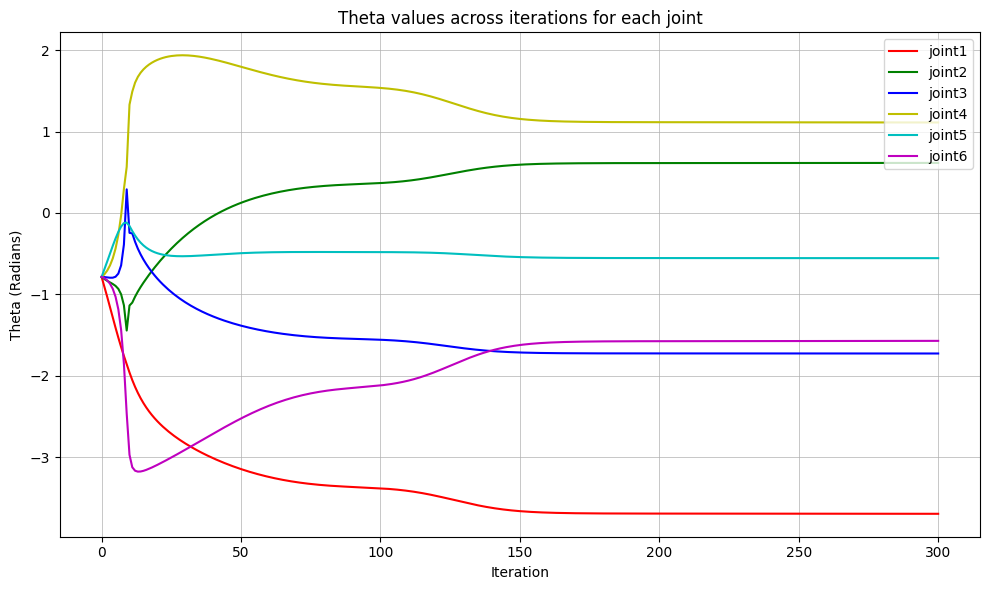

In [7]:
import matplotlib.pyplot as plt

# Plot settings
colors = ['r', 'g', 'b', 'y', 'c', 'm']

tmp_theta_history = np.array(thetas_history)
plt.figure(figsize=(10, 6))
for idx, name in enumerate(rb.joint_names):
    plt.plot(tmp_theta_history[:, idx], linestyle='solid', color=colors[idx], label=name)

plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel('Theta (Radians)')
plt.title("Theta values across iterations for each joint")
plt.grid(True, which='both', linestyle='solid', linewidth=0.5)
plt.tight_layout()
plt.show()

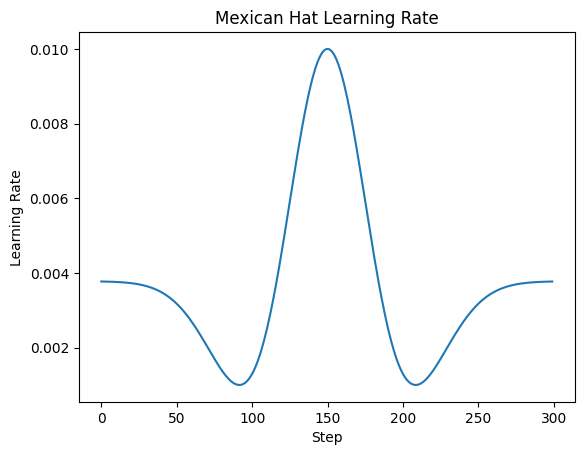

In [8]:
lr_generator = MexicanHatLearningRate(min_lr=0.001, max_lr=0.01, cycle_length=300)
learning_rates = [next(lr_generator) for _ in range(300)]

plt.plot(learning_rates)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Mexican Hat Learning Rate')
plt.show()